In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
import cv2
import numpy as np
from vgg16 import Vgg16

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image

import json
from tqdm import tqdm

from keras.optimizers import SGD, RMSprop, Adam

from utils import *
import cPickle as pickle
from matplotlib import pyplot as plt

from itertools import compress

import shutil


Using TensorFlow backend.


In [2]:
class ImageData(object):

    def __init__(self,id,name):
        self.id = id
        self.name = name
        self.captions = []
        self.image = []
        
    def appendCaption(self,caption):
        self.captions.append(caption)
        
class ImageEntry(object):

    def __init__(self,image,caption):
        self.image = image
        self.caption = caption
        
              

In [3]:
def build_data_dict():
    annotation_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/raw_annotations/captions_val2014.json"
    with open(annotation_path) as data_file:    
        data = json.load(data_file)
        
    id2ImageDataDict = {imageJson["id"]: ImageData(imageJson["id"],imageJson["file_name"]) 
                        for imageJson in data["images"]}
    
    annotationsJson = data["annotations"]
    
    for annotationJson in annotationsJson:
        imageData = id2ImageDataDict[annotationJson["image_id"]]
        caption = annotationJson["caption"]
        imageData.appendCaption(caption)

    fileName2ImageDataDict = {imageJson["file_name"]: id2ImageDataDict[imageJson["id"]] for imageJson in data["images"]}

    return fileName2ImageDataDict

def construct_image_data_arr(base_path,fileName2ImageDataDict):   
    
    image_paths = [f for f in listdir(base_path)]
    
    
    for image_file_name in tqdm(image_paths):
        
        img = PIL.Image.open(base_path+"/"+image_file_name)
        img = img.resize((224, 224), PIL.Image.NEAREST)
        
        image_data = fileName2ImageDataDict[image_file_name]
        
        img = np.asarray(img)
        
        image_data.image = img
        image_data.image = np.asarray(image_data.image)
        
        
        
    all_image_data = [imageData for _,imageData in fileName2ImageDataDict.iteritems()]
    
    filtered_image_data = [imageData for imageData in all_image_data
                      if np.asarray(imageData.image).shape == (224,224,3)]
    

    return  filtered_image_data

def constructImageEntryArr(imageDataArr):
    image_entry_arr = []

    for imageData in imageDataArr:
        image = imageData.image

        for caption in imageData.captions:
            image_entry_arr.append(ImageEntry(image,caption))

    return image_entry_arr

def construct_images_concat_t(image_data_arr):
    image_np_arr = [ np.expand_dims(image_data.image, axis=0) for image_data in image_data_arr]
    images_concat =  np.vstack(image_np_arr)
    images_concat_t = np.transpose(images_concat,(0,3,1,2))
    return images_concat_t


def get_unique_words(captions):
    unique_words = []
    words = [caption.split() for caption in captions]
   
    for word in words:
        unique_words.extend(word)
        
    unique_words = list(set(unique_words))
    
    return unique_words

def get_index_word_dicts(unique_words):
    word_index = {}
    index_word = {}
    for i,word in enumerate(unique_words):
        word_index[word] = i
        index_word[i] = word
        
    return (word_index,index_word)

def get_train_captions_indexed(captions, word2index, MAX_CAPTION_LEN ):
    
    train_captions_indexed = []
    for caption in captions:
        one = [word2index[caption_word] for caption_word in caption.split()]
        train_captions_indexed.append(one)

    train_captions_indexed = sequence.pad_sequences(train_captions_indexed, maxlen=MAX_CAPTION_LEN,padding='post')
    return train_captions_indexed
    
def get_captions_from_batch(path,batch_nr):
    captions = pickle.load(open(path+"captions_batch_"+str(batch_nr)+".p", "rb" ))
    return captions

def get_truncated_captions_from_batch(path,batch_nr,nr_instances):
    captions = get_captions_from_batch(path,batch_nr)
    captions = captions[:nr_instances]
    return captions

def write_captions_to_disk(path,image_data_arr):
    for i in tqdm(range(5)):
        captions = ["START "+image_data.captions[i]+" END" for image_data in image_data_arr] 
        pickle.dump( captions, open(path+"captions_batch_"+str(i)+".p", "wb" ) )
        
        
def compute_partial_all_words_2_next_word(captions_indexed,step_size,temp_save_path):
    
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path)
    
    for window_start in tqdm(range(0,len(captions_indexed),step_size)):
    
        captions_indexed_batch = captions_indexed[window_start:window_start+step_size]

        all_words_2_next_word = []

        for caption_indexed in captions_indexed_batch:

            word_2_next_word = []

            enhanced_caption_indexed = np.append(caption_indexed,[word2index["END"]]) #hacky

            for i in xrange(0,len(caption_indexed)):
                caption_word_index = enhanced_caption_indexed[i]
                future_word_index = enhanced_caption_indexed[i+1]
                future_indexes = np.zeros(VOCAB_SIZE)
                future_indexes[future_word_index] = 1

                word_2_next_word.append(future_indexes)

            words_2_next_word = np.vstack(word_2_next_word)

            all_words_2_next_word.append(words_2_next_word)

        save_array(temp_save_path+ 'all_words_2_next_word__'+str(format(window_start, "06"))+'.bc', all_words_2_next_word)
    
def get_future_words(temp_save_path):
    all_words_2_next_word_paths= [f for f in listdir(temp_save_path)]
    all_words_2_next_word_paths.sort()

    all_words_2_next_word = [load_array(temp_save_path + all_words_2_next_word_path) 
                             for all_words_2_next_word_path in all_words_2_next_word_paths ]

    future_words = np.vstack(all_words_2_next_word)
    future_words = np.transpose(future_words,(0,1,2))
    
    return future_words
    

In [4]:
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/"
images_path = save_path+"raw_images/val2014"
image_data_arr_path = save_path+"imageDataArr/"
images_concat_t_path = save_path+"imagesConcatT/"
captions_path = save_path+"captions/"
temp_save_path = save_path+"temp/"
model_path = save_path+"models/"
images_vgg_features_path = save_path + "images_vgg_features/"

train_path = save_path + "train/"
test_path = save_path + "test/"


images_concat_folder = "images_concat/"
images_vgg_4096_folder = "images_vgg_4096/"
captions_folder = "captions/"

# Build Data - Images

In [5]:
def get_image_data_arr(images_path):
    fileName_2_image_data_dict = build_data_dict()
    image_data_arr = construct_image_data_arr(images_path,fileName_2_image_data_dict)
    return image_data_arr


def get_train_test_data(image_data_arr, test_size):
    train_image_data_arr = image_data_arr[test_size:]
    test_image_data_arr = image_data_arr[:test_size]
    return (train_image_data_arr,test_image_data_arr)
    



In [6]:
TEST_SIZE = 1000

In [ ]:
# image_data_arr = get_image_data_arr(images_path)
# (train_image_data_arr,test_image_data_arr) = get_train_test_data(image_data_arr,TEST_SIZE)
# print("Train: %d Test %d"%(len(train_image_data_arr),len(test_image_data_arr)))
 

In [ ]:
# train_images_concat_t = construct_images_concat_t(train_image_data_arr)
# test_images_concat_t = construct_images_concat_t(test_image_data_arr)
# 
# print(train_images_concat_t.shape)
# print(test_images_concat_t.shape)

In [ ]:
# save_array(train_path + images_concat_folder+ 'images_concat.bc', train_images_concat_t)
# save_array(test_path + images_concat_folder+ 'images_concat.bc', test_images_concat_t)

# Build Data - Captions

In [ ]:
# write_captions_to_disk(train_path + captions_folder, train_image_data_arr)
# write_captions_to_disk(test_path + captions_folder, test_image_data_arr)
        

# Read Serialized Data - Images

In [7]:
all_train_images_concat_t = load_array(train_path + images_concat_folder+ 'images_concat.bc')
test_images_concat_t = load_array(test_path + images_concat_folder+ 'images_concat.bc')

In [8]:
print(all_train_images_concat_t.shape)
print(test_images_concat_t.shape)

(39438, 3, 224, 224)
(1000, 3, 224, 224)


In [46]:
# NR_TRAIN_INSTANCES = len(all_train_images_concat_t)
NR_TRAIN_INSTANCES = 5000

In [47]:
train_images_concat_t = all_train_images_concat_t[:NR_TRAIN_INSTANCES]
print(train_images_concat_t.shape)


(5000, 3, 224, 224)


# Read Serialized Data - Image VGG Features

In [48]:
images_precomputed_vgg_features = load_array(train_path+images_vgg_4096_folder+'vgg_features.bc')
test_images_precomputed_vgg_features = load_array(test_path+images_vgg_4096_folder+'vgg_features.bc')

train_images_precomputed_vgg_features = images_precomputed_vgg_features[:NR_TRAIN_INSTANCES]

In [49]:
print(train_images_precomputed_vgg_features.shape)
print(test_images_precomputed_vgg_features.shape)

(5000, 4096)
(1000, 4096)


# Captions

In [50]:
train_captions = get_truncated_captions_from_batch(train_path + captions_folder, batch_nr = 0, nr_instances = NR_TRAIN_INSTANCES )
test_captions = get_truncated_captions_from_batch(test_path + captions_folder, batch_nr = 0, nr_instances = NR_TRAIN_INSTANCES )
print"Train captions: %d \nTest Captions %d"%(len(train_captions),len(test_captions))

Train captions: 5000 
Test Captions 1000


In [51]:
def get_short_caption_mask(captions, max_length):
    return [len(caption.split()) < max_length for caption in captions]
    
def filter_array_by_mask(arr, mask):
    return np.asarray(list(compress(arr, mask)))

# Filter data by caption length

## Captions

In [52]:
NEW_CAPTION_LENGTH = 15
train_mask_15 = get_short_caption_mask(train_captions,NEW_CAPTION_LENGTH)
test_mask_15 = get_short_caption_mask(test_captions,NEW_CAPTION_LENGTH)

In [53]:
train_captions = filter_array_by_mask(train_captions,train_mask_15)
test_captions = filter_array_by_mask(test_captions,test_mask_15)
print"Train captions: %d \nTest Captions %d"%(len(train_captions),len(test_captions))

Train captions: 4313 
Test Captions 860


## Images

In [54]:
# train_image_model_input = train_images_concat_t
# test_image_model_input = test_images_concat_t

train_image_model_input = train_images_precomputed_vgg_features
test_image_model_input = test_images_precomputed_vgg_features

In [55]:
train_image_model_input = filter_array_by_mask(train_image_model_input,train_mask_15)
test_image_model_input = filter_array_by_mask(test_image_model_input,test_mask_15)
print"Train images: %d \nTest images %d"%(len(train_image_model_input),len(test_image_model_input))

Train images: 4313 
Test images 860


In [56]:
NR_TRAIN_INSTANCES = len(train_captions)

In [57]:
all_captions = np.concatenate((train_captions, test_captions), axis=0) #train_captions+test_captions
                
MAX_CAPTION_LEN = max([len(caption.split()) for caption in all_captions])

unique_words = get_unique_words(all_captions)
VOCAB_SIZE = len(unique_words)
(word2index, index2word) = get_index_word_dicts(unique_words)

train_captions_indexed = get_train_captions_indexed(train_captions, word2index, MAX_CAPTION_LEN )
test_captions_indexed = get_train_captions_indexed(test_captions, word2index, MAX_CAPTION_LEN )

print("Train caption shape %s \nTest caption shape %s "%(str(train_captions_indexed.shape),str(test_captions_indexed.shape)))

Train caption shape (4313, 14) 
Test caption shape (860, 14) 


In [58]:
STEP_SIZE = 500

In [59]:
compute_partial_all_words_2_next_word(train_captions_indexed,STEP_SIZE,temp_save_path)
train_future_words = get_future_words(temp_save_path)
shutil.rmtree(temp_save_path)


compute_partial_all_words_2_next_word(test_captions_indexed,STEP_SIZE,temp_save_path)
test_future_words = get_future_words(temp_save_path)
shutil.rmtree(temp_save_path)

print("Train future words shape %s \nTest future words shape %s "%(str(train_future_words.shape),str(test_future_words.shape)))

100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Train future words shape (4313, 14, 4458) 
Test future words shape (860, 14, 4458) 


In [60]:
print("NR_TRAIN_INSTANCES = %s" % NR_TRAIN_INSTANCES)
print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)


NR_TRAIN_INSTANCES = 4313
MAX_CAPTION_LEN = 14
VOCAB_SIZE = 4458


In [61]:
# (40438, 259, 13601)

# Model Building

## VGG

In [62]:
def get_vgg_model():
    image_model = Vgg16().model
    image_model.pop()
    image_model.pop()
    image_model.trainable = False
    image_model.add(RepeatVector(MAX_CAPTION_LEN))
    return image_model

def get_precomputed_input_model():
    input_model = Sequential()
    input_model.add(RepeatVector(MAX_CAPTION_LEN,input_shape=(4096,)))
    return input_model

## GRU

In [63]:
def get_language_model():
    language_model = Sequential()
    language_model.add(Embedding(VOCAB_SIZE, 256, input_length=MAX_CAPTION_LEN))
    return language_model

In [64]:
def build_model(image_model,language_model):
    model = Sequential()
    model.add(Merge([image_model, language_model], mode='concat'))
    model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax')))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return model


In [65]:
# image_model = get_vgg_model()
image_model = get_precomputed_input_model()
language_model = get_language_model()
model = build_model(image_model,language_model)

In [66]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
repeatvector_3 (RepeatVector)    (None, 14, 4096)      0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 14, 256)       1141248                                      
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 14, 256)       3539712     merge_2[0][0]                    
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribut (None, 14, 4458)      1145706     gru_2[0][0]                      
Total params: 5,826,666
Trainable params: 5,826,666
Non-trainable params: 0
_______________

# Training the model

In [67]:
print("Images : "+str(train_image_model_input.shape))
print("Partial captions : " + str(train_captions_indexed.shape))
print("Future words :" + str(train_future_words.shape))

Images : (4313, 4096)
Partial captions : (4313, 14)
Future words :(4313, 14, 4458)


In [71]:
model.fit??

In [72]:
model.fit([train_image_model_input, train_captions_indexed], train_future_words, batch_size=64, nb_epoch=50, 
          validation_split = 0.2,
          callbacks = [keras.callbacks.TensorBoard(log_dir="/home/docker/fastai-courses/deeplearning1/nbs/courses/deeplearning1/nbs/tf-logs", 
                                                  histogram_freq=0, write_graph=True, write_images=False)])

Train on 3450 samples, validate on 863 samples
Epoch 1/50
3450/3450 [==============================] - 3s - loss: 3.5396 - val_loss: 3.5521

In [ ]:
model.optimizer.lr = 0.0001

In [ ]:
# model.fit([train_image_model_input, train_captions_indexed], future_words, batch_size=64, nb_epoch=1000)

In [73]:
model.evaluate([test_image_model_input, test_captions_indexed], test_future_words, batch_size=64)

832/860 [============================>.] - ETA: 0s

3.7824595717496652

In [ ]:
model.save_weights(model_path+'val_1500_450_precomp.h5')

In [ ]:
# model.load_weights(model_path+'val_1500_5.h5')
model.load_weights(model_path+'val_1500_200_precomp.h5')

In [ ]:
# print(np.average(image_model.get_weights()[0].shape))
print(np.average(language_model.get_weights()[0].shape))

In [ ]:
# print(np.average(image_model.get_weights()[0].shape))
print(np.average(language_model.get_weights()[0].shape))

# Testing the model

In [34]:
vgg_model = get_vgg_model()

In [39]:
def get_test_model(model):
    
    test_model = Sequential()
    test_model.add(Merge([vgg_model, language_model], mode='concat'))
    for layer in model.layers[1:]:
        test_model.add(layer)
        
    test_model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return test_model

def plot_predictions(ims, titles):  
    for i in range(len(ims)):
        plt.title(titles[i])
        plt.imshow(ims[i])
        plt.figure()
            
    plt.show()
    
def make_prediction(random_number,vgg_model):
    startIndex = word2index["START"]
    start_captions = [[startIndex]]
    start_captions = sequence.pad_sequences(start_captions, maxlen=MAX_CAPTION_LEN,padding='post')

    firstImage = np.expand_dims(test_images_concat_t[random_number], axis=0)

    first_image_vgg_features = vgg_model.predict(firstImage)
#     first_image_input = firstImage
    first_image_input = np.squeeze(first_image_vgg_features)[0].reshape(1,4096)
    
    firstCaption = np.expand_dims(start_captions[0], axis=0) 

    outputs = []

    endGenerated = False
    i = 0
    while ((not endGenerated) & (i < MAX_CAPTION_LEN-1)):
    # for i in range(17):
        predictions = model.predict([first_image_input, firstCaption])
        predictions = predictions[0]

        currentPred = predictions[i]

        max_index = np.argmax(currentPred)

    #     top3_max_indexes = predictions.argsort()[-4:][::-1]

    #     max_index = top3_max_indexes[3]
    #     print(predictions.shape)

        outputs.append(max_index)
        firstCaption[0,i+1] = max_index

        i+=1

        if(index2word[max_index] == "END"):
            endGenerated = True

    caption = ' '.join([index2word[x] for x in firstCaption[0][:i+1]])
    
    drawImage = firstImage[0]
    drawImageT = np.transpose(drawImage,(1,2,0))
    plt.imshow(drawImageT)
    
    return (drawImageT,caption)

In [76]:
NO_TEST_IMAGES = 10
TEST_WINDOW_START = 200

images2Captions = [make_prediction(i,vgg_model) 
                   for i in range(TEST_WINDOW_START,TEST_WINDOW_START+NO_TEST_IMAGES)]
images = [image2Caption[0] for image2Caption in images2Captions]
captions = [image2Caption[1] for image2Caption in images2Captions]


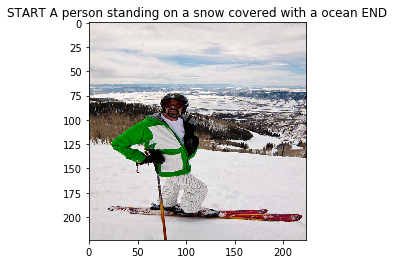

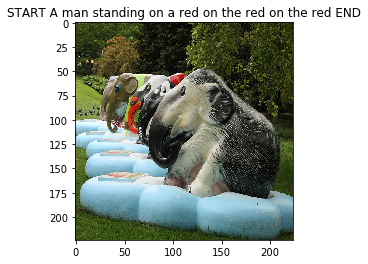

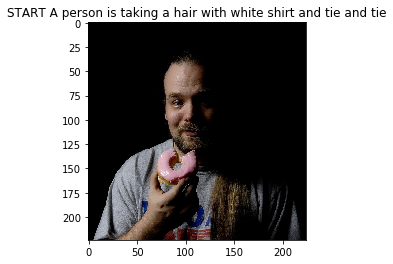

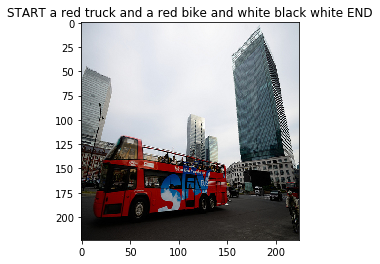

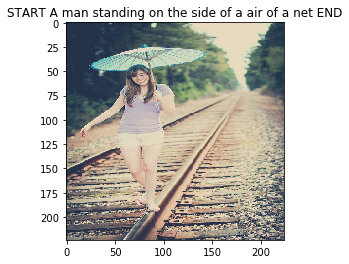

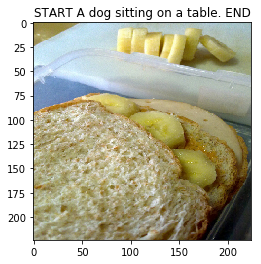

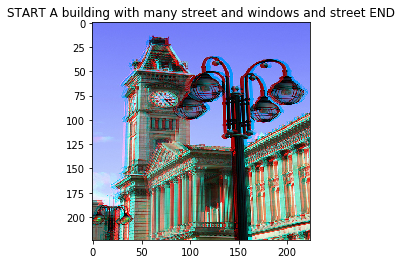

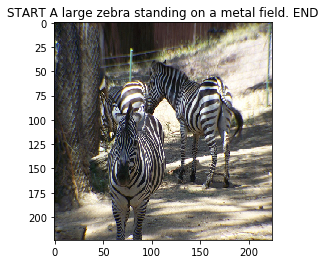

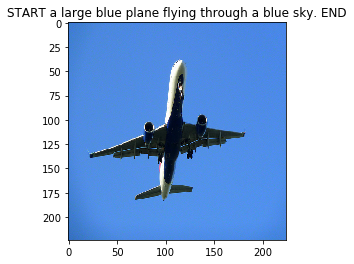

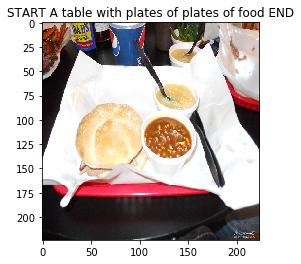

In [77]:
plot_predictions(images,titles = captions)